In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sympy as sy
import simtk.unit as unit
from simtk import openmm as mm
from simtk.openmm import app
import skopt as skopt
from tqdm import tqdm

# 3D Liquid Argon model

In [21]:
n_particles = 1000
reduced_density = 0.75
mass = 39.948 * unit.amu
sigma = 3.404 * unit.angstroms
epsilon = 0.238 * unit.kilocalories_per_mole
charge = 0.0 * unit.elementary_charge

temperature = 300.0 * unit.kelvin

integration_timestep = 0.01 * unit.picoseconds # 2 Ar particles small oscillations period: 1.27 ps
collisions_rate = 1.0 / unit.picoseconds

equilibration_time = 1.0 * unit.nanoseconds

production_time = 10.0 * unit.nanoseconds
saving_time = 20.0 * unit.picoseconds

equilibration_n_steps = round(equilibration_time/integration_timestep)

The Van der Waals radius of Argon is 1.88 angstroms.

In [22]:
radius = 2.0**(-5/6) * sigma
print(radius)

1.9104304062225528 A


In [23]:
volume_particles = n_particles * sigma**3
volume = volume_particles/reduced_density
l_box = volume**(1/3)

print('Side of the box: {}'.format(l_box))

Side of the box: 37.46586785079102 A


In [24]:
system = mm.System()

In [25]:
v1 = np.zeros(3) * unit.angstroms
v2 = np.zeros(3) * unit.angstroms
v3 = np.zeros(3) * unit.angstroms

v1[0] = l_box
v2[1] = l_box
v3[2] = l_box

system.setDefaultPeriodicBoxVectors(v1, v2, v3)

In [26]:
non_bonded_force = mm.NonbondedForce()
non_bonded_force.setNonbondedMethod(mm.NonbondedForce.CutoffPeriodic)
non_bonded_force.setCutoffDistance(3.0*sigma)
non_bonded_force.setUseSwitchingFunction(True)
non_bonded_force.setSwitchingDistance(2.0*sigma)
non_bonded_force.setUseDispersionCorrection(True)

In [27]:
for _ in range(n_particles):
    system.addParticle(mass)
    non_bonded_force.addParticle(charge, sigma, epsilon)

In [28]:
_ = system.addForce(non_bonded_force)

In [29]:
integrator = mm.LangevinIntegrator(temperature, collisions_rate, integration_timestep)
platform = mm.Platform.getPlatformByName('CUDA')
context = mm.Context(system, integrator, platform)

In [30]:
space = skopt.Space([[0.0, l_box._value], [0.0, l_box._value], [0.0, l_box._value]])
grid_generator = skopt.sampler.Grid(use_full_layout=False)
initial_positions = grid_generator.generate(space.dimensions, n_particles)
initial_positions = np.array(initial_positions)*unit.angstroms

In [31]:
context.setPositions(initial_positions)
context.setVelocitiesToTemperature(temperature)

In [32]:
state=context.getState(getEnergy=True)
print("Before minimization: {}".format(state.getPotentialEnergy()))
mm.LocalEnergyMinimizer_minimize(context)
state=context.getState(getEnergy=True)
print("After minimization: {}".format(state.getPotentialEnergy()))

Before minimization: 194558882.0758952 kJ/mol
After minimization: -5971.461702454637 kJ/mol


In [33]:
equilibration_n_steps = round(equilibration_time/integration_timestep)
integrator.step(equilibration_n_steps)
context.setTime(0.0*unit.picoseconds)

In [34]:
production_n_steps = int(production_time/integration_timestep)
saving_n_steps = int(saving_time/integration_timestep)
n_saving_periods = int(production_n_steps/saving_n_steps)

time = np.zeros([n_saving_periods]) * unit.nanoseconds
trajectory = np.zeros([n_saving_periods, n_particles, 3]) * unit.angstroms
potential_energy = np.zeros([n_saving_periods]) * unit.kilocalories_per_mole

for ii in tqdm(range(n_saving_periods)):
    integrator.step(saving_n_steps)
    #remove enforcePeriodicBox to get unwrapped trajectories
    state = context.getState(getPositions=True, getEnergy=True, enforcePeriodicBox = False)
    time[ii] = state.getTime()
    trajectory[ii,:,:] = state.getPositions(asNumpy=True)
    potential_energy = state.getPotentialEnergy()

100%|██████████| 500/500 [02:54<00:00,  2.87it/s]


In [35]:
trajectory_mem = trajectory.size * trajectory.itemsize * unit.bytes
print('Trajectory size: {} MB'.format(trajectory_mem._value/(1024*1024)))

Trajectory size: 11.444091796875 MB


In [36]:
trajectory.max()

Quantity(value=5189466278.391298, unit=angstrom)

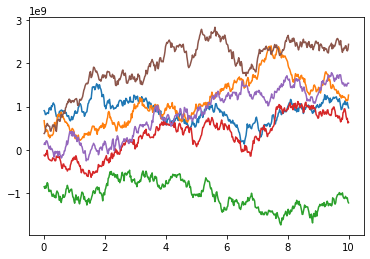

In [38]:
plt.plot(time, trajectory[:,0,0])
plt.plot(time, trajectory[:,0,1])
plt.plot(time, trajectory[:,0,2])
plt.plot(time, trajectory[:,100,0])
plt.plot(time, trajectory[:,100,1])
plt.plot(time, trajectory[:,100,2])

- Calcular difusion de las partículas
- Calcular RDF
- Energy
- Sensibilidad frente a integration_timestep
- Cuando converge
- Empezar con una grid (muy fuera del equilibrio)... cuando tengo una estructura más equilibrada?
- Empezar con otro tipo de distribución aleatoria o quasi-aleatoria y ver si converge más rapidamente.
- Aplicar barostato
- Cambiar el integrador, de langevin a verlet por ejemplo, la termodinámica converge antes?
- Sacar magnitudes de equilibrio haciendo montecarlo